<a href="https://colab.research.google.com/github/teegwende/WQPandEntitiesDensity/blob/main/traitma_ordi_wavelet_Mensuel2_tsParamSaufFlw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [16]:
from pandas import read_csv, DataFrame
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)


######################################################## CHOIX DATASET #############################################################
jeu_donnees=int(input('1-jeu Panamasso 2-UCAD'))
if jeu_donnees==1:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/feed_new.csv', index_col='DATE', parse_dates=True)
    # df=df.drop(columns=['entry_id','latitude','longitude','elevation','status'])
    df=df.drop(columns=['entry_id','status'])
if jeu_donnees==2:
    df = read_csv('/gdrive/MyDrive/traitement_ordinaire/datarep/data_ucad.csv', index_col='DATE', parse_dates=True)
    #df=df.drop(columns=['entry_id','latitude','longitude','elevation','status'])

######################################################"PREPROCESSING##################################################################
##########################################ELIMINATION VALEURS ABERRANTES##############################################################
#évaluation des plages des valeurs 
plage = {"PH":[1,14],
        "TEMP":[0,60],
         "DO" :[-1,20],
         "EC2":[0,20000], #muS/cm
         } 

# plage = {"PH":[0,14],
#         "TEMP":[0,60],
#          "EC2":[0,20000], #muS/cm
#          } 
#dataparams = list()
dataparams={}  # Noter que l'algo est de créer un dico avec comme clé chaque param
for col in df.columns:
    if not plage.get(col)==None:
        sub=df.loc[ ~ (  (df[col]<=plage.get(col)[0])  | (df[col]>=plage.get(col)[1]) ) ][col]
        dataparams[col]=sub

1-jeu Panamasso 2-UCAD1


In [ ]:
# dataparams.get("DO")

In [17]:
####################################################DIFFRENTES FONCTIONS#########################################################
###############################################FONCTION IMPUTATION##############################################################
import numpy as np
import math 
from pandas import concat

def imputation(ledataframe):
    # params=["PH","TEMP","EC","DO","FLW"]
    params=["PH","TEMP","DO","EC2"]
    # params=["DO"]
    # params=["PH","TEMP","EC2"]
    cols=list()
    for param in params:
        data=dataparams.get(param).resample('D').mean()
        i=0
        j=0
        for index, row in data.items():   
            if(i==data.size):
                break
            if math.isnan(data.iloc[i]):
                val1=data.iloc[i-1] #On stocke la premiere valeur de calcul de la moyenne
                j=i
                # print("j=",j)
                while math.isnan(data.iloc[j]): #on saute toutes les autres valeurs nan
                    j=j+1
                    # print("j2nd=",j)
                val2=data.iloc[j]
                k=i
                while k<j: #on remonte pour remplacer les valeurs nan par la moyenne
                    data.iloc[k]=(val1+val2)/2
                    k=k+1
                i=j #i redevient j pour qu'on continue avec les valeurs suivantes
            else:
                i=i+1
        cols.append(data)
    agg=concat(cols,axis=1)
    agg.columns=params
    return agg
  

###############################################FONCTION DIVISION DES DONNEES###########################################################
def diviserdata(periode,donnees):
  train,test=donnees.loc[donnees.index <= periode],donnees.loc[donnees.index> periode]
  return train,test

train_SimpleImput,test_SimpleImput=diviserdata("04-2021",pd.DataFrame(dataparams).resample('D').mean())
train_PersoImput, test_PersoImput=diviserdata("04-2021",imputation(pd.DataFrame(dataparams).resample('D').mean()))
train_SimpleImput_index=train_SimpleImput.index
test_SimpleImput_index=test_SimpleImput.index

<Figure size 1080x432 with 0 Axes>

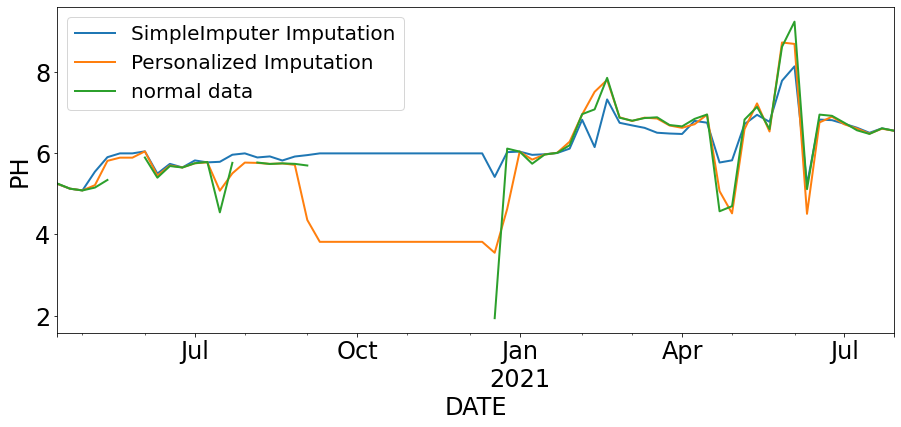

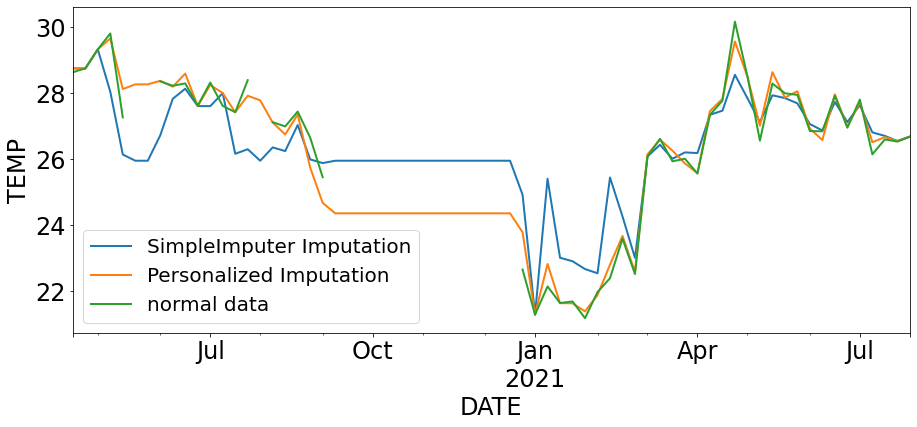

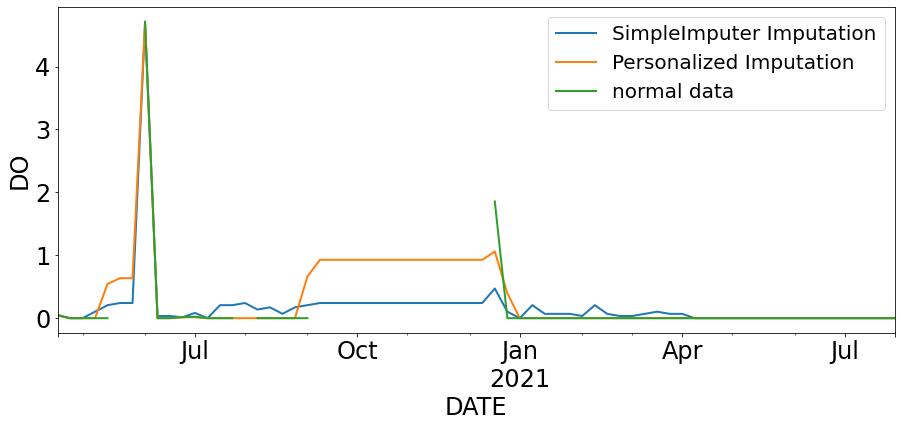

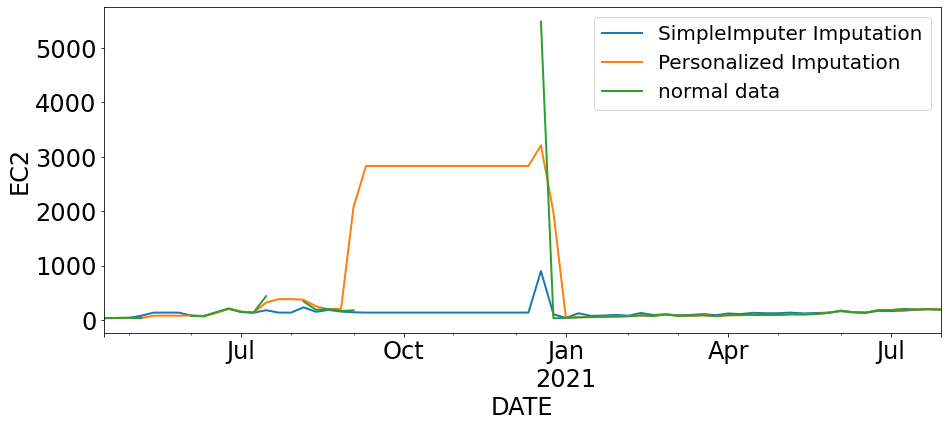

In [18]:
######################################################## GENERATION DE GRAPHES #####################################

#Appliquer le imputter
from sklearn.impute import SimpleImputer

imputerTrain= SimpleImputer(missing_values=np.nan,strategy='mean')
train_S_I_imput=imputerTrain.fit_transform(train_SimpleImput)

imputerTest= SimpleImputer(missing_values=np.nan,strategy='mean')
test_S_I_Imput=imputerTest.fit_transform(test_SimpleImput)
train_SimpleImput_index=train_SimpleImput.index
train_S_I_imput=pd.DataFrame(train_S_I_imput,index=train_SimpleImput_index)
test_S_I_Imput=pd.DataFrame(test_S_I_Imput,index=test_SimpleImput_index)

data_SimpleImput=pd.concat([train_S_I_imput,test_S_I_Imput],axis=0)
data_SimpleImput.columns=["PH","TEMP","DO","EC2"]
# data_SimpleImput.columns=["PH","TEMP","EC2"]


############################################### LES GRAPHES ######################################################
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '24'
plt.figure(figsize=(15,6))
""""dtt=dataframe_set["TEMP"]
dtt2=imputation("TEMP")
dtt3=dataparams.get("TEMP")"""
for param in ["PH","TEMP","DO","EC2"]:
# for param in ["PH","TEMP","EC2"]:
  plt.figure(figsize=(15,6))
  dtt=data_SimpleImput[param]
  dtt2=imputation(pd.DataFrame(dataparams).resample('W').mean())[param]
  dtt3=pd.DataFrame(dataparams).resample('W').mean()[param]
  # print(type(dtt))
  # print(type(dtt2))
  # print(type(dtt3))
  dtt.resample('W').mean().plot(label='SimpleImputer Imputation',lw=2)
  dtt2.resample('W').mean().plot(label='Personalized Imputation',lw=2)
  dtt3.resample('W').mean().plot(label='normal data',lw=2)
  plt.legend(loc=0,fontsize=20)
  # parameter = " Temperature " if param=="TEMP" else " PH "
  parameter = param
  plt.ylabel(parameter)
  #plt.title("SimpleImputer and Personalized imputation methods applied on"+parameter +"data")
  plt.savefig("/gdrive/MyDrive/traitement_ordinaire/comparison_imputation"+param+".pdf",dpi=600)
  plt.show()
#dtt.loc['2021'].resample('W').mean().plot()

In [19]:
###############################################DIFFRENTES FONCTIONS SUITE########################################################
###############################################FONCTION NORMALISATION############################################################

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler(feature_range=(0, 1)) # instance de la classe MinMaxScaler
#scaler = StandardScaler() # instance de la classe MinMaxScaler
#scaler = RobustScaler() # instance de la classe MinMaxScaler
#Normalization process
def normaliser(donnees):
    resultat = scaler.fit_transform(donnees) #transformation du dataset via une méthode de l'instance de MinMaxScaler
    #test_temp = scaler.fit_transform(test_temp)
    return resultat

########################################FONCTION TRANSFORMATION FORMAT SUPERVISE#################################################
#Préparation des données à entrainer
#Transformation des series temporelles en jeu de donnees supervisee 
#times series vers cross-sectional data (c'est un peu les termes techniques)
from pandas import concat
def preparationData(donnees, nbValPrec=1, nbValSuiv=1,dropnan=True):
    #params=["ind0","ind1","DATE","PH","TEMP"]
    params=["DATE","PH","TEMP","DO","EC2"]
    # params=["DATE","PH","TEMP","EC2"]
    #params=["PH","TEMP"]
    n_vars = 1 if type(donnees) is list else donnees.shape[1]
    df = DataFrame(donnees)
    newdf=df.reset_index(drop=False)
    #print(newdf)
    cols, names = list(), list()
    #Les valeurs précédentes à considérer
    for i in range(nbValPrec, 0, -1):
        cols.append(newdf.shift(i))
        #param='TEMP'
        #names += [('temp%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [(param+'(t-%d)' % (i)) for param in params ]
    #La longueur de prédiction
    for i in range(0, nbValSuiv):
        cols.append(newdf.shift(-i))
        if i == 0:
            #names += [('temp%d(t)' % (j+1)) for j in range(n_vars)]
            names += [(param+'(t)') for param in params ]
        else:
            #names += [('temp%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            names += [(param+'(t+%d)' % (i)) for param in params ]
    #Le dataset final
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

###############################################FONCTION COMPELTION DATA COEF WAVELET##########################################################
#Algo pour compléter un nombre pour obtenir le multiple de son diviseur
#Récupérer le reste de la division
#Soustraire le reste du coeficient
#additionner le resultat de la soustraction au nombre initial
# Import math Library
import math 
def completerData(donnees):
    level=3
    nombredezeros= int(math.pow(2,level))- ( len(donnees) % int(math.pow(2,level))   )
    pad_arr = np.pad(donnees, (0,nombredezeros), 'constant', constant_values=(0))
    return pad_arr

###############################################FONCTION FORMATION DATASET POUR WANN ##########################################################
#Elabaration du newinput
import pywt
from pandas import concat
def createnewinput(donnees,wavelet,level):
    newinput=list()
    for i in range(donnees.shape[1]):
        newdf=completerData(donnees[:, i]) #il complète le nombre de zéros nécessaires
        #coefswt=pywt.swt(newdf,'haar',level=3,norm=True,axis=0) #ici il calcule les coefficients
        coefswt=pywt.swt(newdf,wavelet,level=level,norm=True,axis=0) #ici il calcule les coefficients
        newinput.append(pd.Series(coefswt[0][0]))
        for coef in coefswt:
            newinput.append(pd.Series(coef[1]))
    agg=concat(newinput,axis=1)
    return agg

###############################################FONCTION FFN ##########################################################
import keras
from keras.layers import Dense,Activation,Flatten
from keras.models import Sequential

#Fonction FFN
def ffn2(hiddenNodes,nb_obs,n_features,horizon,dim):
    model=Sequential()
    model.add(Dense(hiddenNodes,input_dim= dim )) #REmplacer le input_shape par input_dim
    #model.add(Dropout(0.3))
    #model.add(Flatten())
    model.add(Dense(n_features*horizon)) #changement de horizon par y.shape[1]
    model.compile(optimizer="adam", loss ="mean_squared_error")
    return model 

################################################ FONCTION LSTM ####################################################
def lstmfn(hiddenNodes,nb_obs,n_features,horizon):
  model = keras.Sequential()
  model.add(LSTM(units = hiddenNodes,input_shape = (1,nb_obs*n_features))) #A CHANGER LE 1 PAR n_features POUR INDIQUER 2 VARIABLES
  #model.add(LSTM(nb_obs*n_features)) # Si on désactive ça , c'est qu'on souhaite faire du LSTMStacked. Ne pas oublier de faire du return sequence=True
  #model.add(Dropout(0.3))
  model.add(Dense(horizon*n_features))
  model.compile(optimizer = 'adam', loss ="mean_squared_error")
  #model.compile(optimizer=optimizer, loss ="mean_squared_error",metrics="mse")
  return model

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
##############################################FONCTIONS DE VISUALISATION DES RESULTATS #############################################""
def visualPrediction(param,periode,donneestest,donneesPredite,nb_obs,horizon,nbrefois,directory):
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(pd.to_datetime(periode),donneestest,'o-',label='Donnees Test')

  for v,p in zip(donneestest,periode):
    ax.annotate(round(v,2),xy=(p,v),fontsize=10)

  ax.plot(pd.to_datetime(periode),donneesPredite,'o-',label='Donnes Predites')

  for v,p in zip(donneesPredite,periode):
    ax.annotate(round(v,2),xy=(p,v),fontsize=10)

  ax.set(xlabel="Date", ylabel=param,
       title=lamethode+" "+param+" Lag"+str(nb_obs)+" Horizon="+str(horizon))
  ax.legend()

  # Format the x axis
  #ax.xaxis.set_major_locator(mdates.DayLocator(interval=horizon))
  ax.xaxis.set_major_locator(mdates.DayLocator())
  ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
  plt.xticks(rotation=90, ha='right',fontsize=14)
  #plt.xlim(periode[0],periode[20])
  plt.savefig(directory+lamethode+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+param+'.pdf')
  
  plt.show()
  plt.close()

####Noter que dans cette fonction, on peut juste retenir la dernière colonne de l'horizon recherché
###Tout comme on peut plotter toutes les valeurs prédites de depuis parm (t) jusqu'à parm(t-+horzion-1)
def visualCalibrationPlot(param,donneestest,donneesPredite,nbrefois,directory,periode):
  plt.figure(figsize=(15,6))
  #plt.plot(donneestest[-len(periode):],donneestest[-len(periode):],c='black')
  #plt.scatter(donneestest[-len(periode):],donneesPredite[-len(periode):],c='blue',alpha=0.6)
  plt.plot(donneestest,donneestest,c='black')
  plt.scatter(donneestest,donneesPredite,c='blue',alpha=0.6)
  plt.xlabel(param+" Attendue")
  plt.ylabel(param+" Prédite")
  plt.savefig(directory+lamethode+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+param+'.pdf')
  plt.show()
  plt.legend(loc=0)
  plt.close()

In [21]:
#Cellule de test
def retrouverDatesPred(obs,horizon,donnees):
  lesdatespred=donnees.loc[:, donnees.columns.str.contains("DATE\(t\+|DATE\(t\)")]
  datespred=[]

  for i in range(0,len(lesdatespred),horizon):
    for j in range(horizon):
      datespred.append(lesdatespred.iloc[i, j])
  return datespred

# def retrouverDonneesPred(obs,horizon,donnees):

horizon=90
obs=10
donnees=preparationData(test_S_I_Imput,obs,horizon)

result=retrouverDatesPred(obs,horizon,donnees)

donnespred=[]
lestarget=donnees.loc[:,~donnees.columns.str.contains("DATE")]
lestargetPred=lestarget.iloc[:, -horizon*4:]

# for l in lestargetPred:
#   print(l)

display(lestarget.head(10))
print(len(lestargetPred.values))
print(len(lestargetPred.values.reshape(-1)))
print(len(result))
# train.iloc[:,:nb_obs*n_features].values,train.iloc

# for i in range(0,len(lesdatespred)+1,horizon):
#     # print(lesdatespred.iloc[i, 0], lesdatespred.iloc[i, 2])
#   # print(lesdatespred.iloc[i, 0:horizon])
#   for j in range(horizon):
#     datespred.append(lesdatespred.iloc[i, j])

# # donnees.loc[20:20:,]
# donnees.loc[:, donnees.columns.str.contains("DATE\(t\+|DATE\(t\)")]
# donnees=donnees.loc[:,~donnees.columns.str.contains("DATE")]
# donnees.loc[:,~donnees.columns.str.contains("\(t-\)")]

# # donnees.loc[:, donnees.columns.str.contains("DATE\(t\+|DATE\(t\)")]
# donnees=donnees.loc[:,~donnees.columns.str.contains("DATE")]
# #train_dates=donnees.loc[:, donnees.columns.str.contains("DATE\(t\+|DATE\(t\)")]
# #train_dates
# X_train,y_train = donnees.iloc[:,:3*4].values,donnees.iloc[:, -2*4:].values
# y_train

,PH(t-10),TEMP(t-10),DO(t-10),EC2(t-10),PH(t-9),TEMP(t-9),DO(t-9),EC2(t-9),PH(t-8),TEMP(t-8),...,DO(t+87),EC2(t+87),PH(t+88),TEMP(t+88),DO(t+88),EC2(t+88),PH(t+89),TEMP(t+89),DO(t+89),EC2(t+89)
10,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,6.667,26.189,...,0.000,150.206,6.667,27.336,0.000,150.206,6.673,25.060,0.000,205.000
11,6.667,27.336,0.000,150.206,6.667,26.189,0.000,77.143,6.667,27.336,...,0.000,150.206,6.673,25.060,0.000,205.000,6.393,25.880,0.000,214.286
12,6.667,26.189,0.000,77.143,6.667,27.336,0.000,150.206,6.377,28.796,...,0.000,205.000,6.393,25.880,0.000,214.286,6.506,25.880,0.000,200.000
13,6.667,27.336,0.000,150.206,6.377,28.796,0.000,77.143,6.667,27.336,...,0.000,214.286,6.506,25.880,0.000,200.000,6.463,26.560,0.000,208.571
14,6.377,28.796,0.000,77.143,6.667,27.336,0.000,150.206,6.107,27.170,...,0.000,200.000,6.463,26.560,0.000,208.571,6.460,26.293,0.000,180.000
15,6.667,27.336,0.000,150.206,6.107,27.170,0.000,96.667,7.181,27.109,...,0.000,208.571,6.460,26.293,0.000,180.000,6.357,26.630,0.000,208.571
16,6.107,27.170,0.000,96.667,7.181,27.109,0.000,90.000,7.206,27.859,...,0.000,180.000,6.357,26.630,0.000,208.571,6.393,27.360,0.000,187.143
17,7.181,27.109,0.000,90.000,7.206,27.859,0.000,105.000,7.333,25.717,...,0.000,208.571,6.393,27.360,0.000,187.143,6.667,27.336,0.000,150.206
18,7.206,27.859,0.000,105.000,7.333,25.717,0.000,105.000,6.667,27.336,...,0.000,187.143,6.667,27.336,0.000,150.206,6.646,26.784,0.000,191.429
19,7.333,25.717,0.000,105.000,6.667,27.336,0.000,150.206,6.667,27.336,...,0.000,150.206,6.646,26.784,0.000,191.429,6.629,27.000,0.000,205.000


22
7920
90


In [22]:
##########################################DEFINITION DE LA CLASSE MLOG POUR STOCKER DES INFOS DES MODELES ##############################""
class MLogs:
  imput=''
  normalized=''
  method=''
  listrmse=''
  listmae=''
  listmodel=''

  def __init__(self,method,listrmse,listmae,listR2,listmodel,listBestParam,listResultCv):
    self.method=method
    self.listrmse=listrmse
    self.listmae=listmae
    self.listmodel=listmodel
    self.listR2=listR2
    self.listBestParam=listBestParam
    self.listResultCv=listResultCv 
  
  def minrmse(self):
    i_mini=0
    mini=self.listrmse[0]
    for i in range(len(self.listrmse)):
        if(mini>self.listrmse[i]):
            mini=self.listrmse[i]
            i_mini=i
    #return mini
    return mini,self.listmodel[i_mini],self.listBestParam[i_mini],self.listResultCv[i_mini]
  
  def minmae(self):
    i_mini=0
    mini=self.listmae[0]
    for i in range(len(self.listmae)):
      if(mini>self.listmae[i]):
          mini=self.listmae[i]
          i_mini=i
    #return mini
    return mini,self.listmodel[i_mini],self.listBestParam[i_mini],self.listResultCv[i_mini]

  def maxr2(self):
    i_max=0
    maxi=self.listR2[0]
    for i in range(len(self.listR2)):
      if(maxi<self.listR2[i]):
          maxi=self.listR2[i]
          i_max=i
    #return mini
    return maxi,self.listmodel[i_max],self.listBestParam[i_max],self.listResultCv[i_max]
  
  def mlog(self):
    props=list()
    rmse,modelrmse,bestParamRMSE,resultcvRMSE=self.minrmse()
    mae,modelmae,bestParamMAE,resultcvMAE=self.minmae()
    r2,modelr2,bestParamR2,resultcvR2=self.maxr2()

    props.append(self.method)
    props.append(rmse)
    props.append(modelrmse)
    props.append(bestParamRMSE)
    props.append(resultcvRMSE)

    props.append(mae)
    props.append(modelmae)
    props.append(bestParamMAE)
    props.append(resultcvMAE)

    props.append(r2)
    props.append(modelr2)
    props.append(bestParamR2)
    props.append(resultcvR2)
    return props

  def mlogall(self):
    valeurs=list()
    #valeurs.append(self.method)
    valeurs.append(self.listmodel)
    valeurs.append(self.listrmse)
    valeurs.append(self.listmae)
    return valeurs

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,7.091,27.625,-0.005,92.039,7.129,27.678,-0.009,91.358,7.103,27.699,...,0.107,150.057,6.662,26.475,0.113,150.461,6.671,26.410,0.104,150.108
1,7.101,27.667,0.008,92.018,7.132,27.683,-0.002,91.660,7.082,27.710,...,0.115,150.471,6.669,26.417,0.102,150.200,6.654,26.486,0.121,151.177
2,7.159,27.657,0.014,92.422,7.158,27.690,0.006,92.389,7.164,27.745,...,0.103,150.232,6.654,26.488,0.119,151.149,6.670,26.458,0.100,150.373
3,7.127,27.632,0.011,92.929,7.177,27.663,-0.002,92.677,7.117,27.684,...,0.113,150.677,6.669,26.459,0.101,150.437,6.663,26.506,0.110,150.659
4,7.035,27.993,0.004,93.168,7.037,27.962,-0.008,92.922,7.109,27.951,...,0.111,150.723,6.663,26.507,0.107,150.624,6.669,26.488,0.102,150.115


,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,6.667,27.336,...,0.000,150.206,6.667,27.336,0.000,150.206,6.673,25.060,0.000,205.000
1,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,6.546,30.063,...,0.000,150.206,6.673,25.060,0.000,205.000,6.393,25.880,0.000,214.286
2,6.667,27.336,0.000,150.206,6.546,30.063,0.000,97.143,6.667,27.336,...,0.000,205.000,6.393,25.880,0.000,214.286,6.506,25.880,0.000,200.000
3,6.546,30.063,0.000,97.143,6.667,27.336,0.000,150.206,6.667,27.336,...,0.000,214.286,6.506,25.880,0.000,200.000,6.463,26.560,0.000,208.571
4,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,7.351,25.457,...,0.000,200.000,6.463,26.560,0.000,208.571,6.460,26.293,0.000,180.000


shape test= (22, 360)


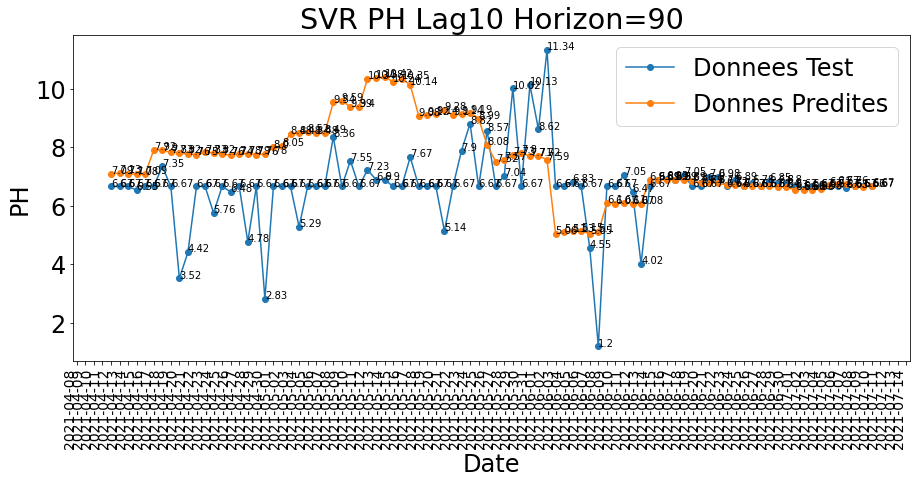

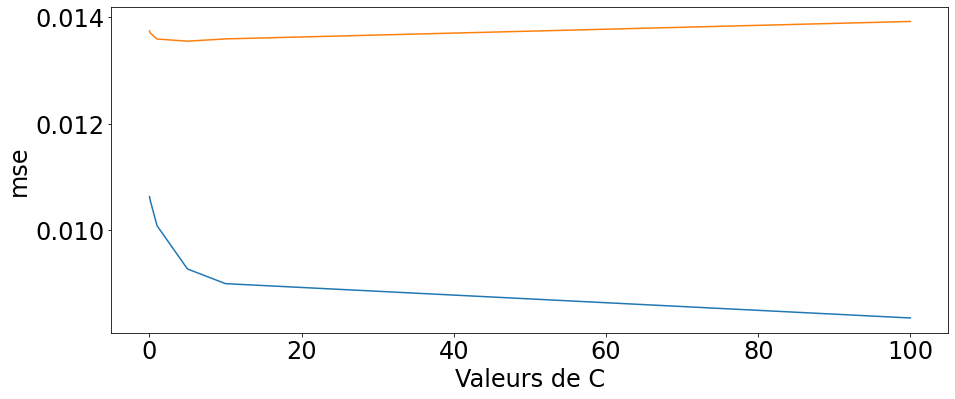

Enregistrement Log
Epoch 1/100
8/8 [==============================] - 2s 60ms/step - loss: 0.2180 - val_loss: 0.1855
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 0.1753 - val_loss: 0.1413
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.1140 - val_loss: 0.0858
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0507 - val_loss: 0.0482
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0238 - val_loss: 0.0455
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0366
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0311
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0310
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0313
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0322
Epoch 11/

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,8.430,25.728,-0.217,94.069,8.371,24.790,-0.186,90.034,8.602,24.407,...,0.023,149.338,6.863,27.320,0.080,149.552,6.892,27.254,0.037,148.524
1,8.098,24.687,-0.205,91.180,8.179,24.212,-0.238,91.003,8.493,23.880,...,0.023,150.559,6.826,27.173,0.067,151.568,6.836,27.221,0.045,151.560
2,8.155,25.392,-0.172,92.908,8.452,24.798,-0.137,90.713,8.222,24.408,...,0.042,154.030,6.849,27.235,0.041,152.071,6.805,27.110,-0.020,148.872
3,8.455,24.842,-0.206,92.345,8.608,24.551,-0.186,90.622,8.667,24.143,...,0.032,153.339,6.887,27.337,0.068,153.009,6.868,27.295,-0.004,149.077
4,8.356,25.540,-0.180,92.390,8.814,25.132,-0.073,90.928,8.645,24.466,...,0.018,155.326,6.898,27.376,0.034,151.963,6.816,27.249,-0.034,150.685


,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,6.667,27.336,...,0.000,150.206,6.667,27.336,0.000,150.206,6.673,25.060,0.000,205.000
1,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,6.546,30.063,...,0.000,150.206,6.673,25.060,0.000,205.000,6.393,25.880,0.000,214.286
2,6.667,27.336,0.000,150.206,6.546,30.063,0.000,97.143,6.667,27.336,...,0.000,205.000,6.393,25.880,0.000,214.286,6.506,25.880,0.000,200.000
3,6.546,30.063,0.000,97.143,6.667,27.336,0.000,150.206,6.667,27.336,...,0.000,214.286,6.506,25.880,0.000,200.000,6.463,26.560,0.000,208.571
4,6.667,27.336,0.000,150.206,6.667,27.336,0.000,150.206,7.351,25.457,...,0.000,200.000,6.463,26.560,0.000,208.571,6.460,26.293,0.000,180.000


shape test= (22, 360)


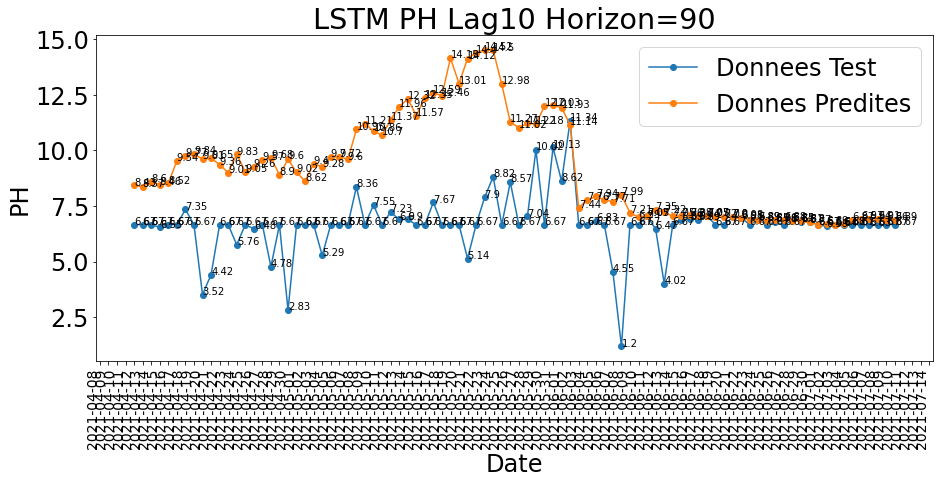

ValueError: ignored

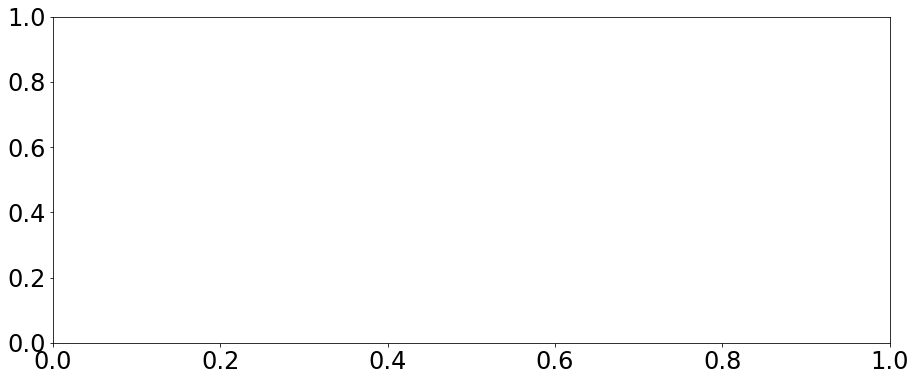

In [52]:
############################################## EXECUTION ###########################################

from sklearn.svm import SVR
from sklearn.multioutput import RegressorChain,MultiOutputRegressor
from math import sqrt 
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, learning_curve, validation_curve
from keras.wrappers.scikit_learn import KerasRegressor
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import csv
import pickle

from datetime import datetime, timedelta
import os

import pywt 

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

log_O_svm=list()
log_O_lstm=list()
log_N_svm=list()
log_N_lstm=list()
log_O_wann=list()
log_N_wann=list()


listdesLogs=[]
  #def minrmse(self,listrmse):

listHistory={}
listHistory2={} # pour wann
#Création du dossier des graphes
now = datetime.now()
directory=str('/gdrive/MyDrive/traitement_ordinaire/' +str( now.strftime(("%d_%b_%Y_%H_%M")) ) )
if not os.path.exists(directory):
    os.mkdir(directory)

# donnees_train=train_PersoImput 
# donnees_test=test_PersoImput
donnees_train=train_S_I_imput 
donnees_test=test_S_I_Imput

for nbrefois in range(1,2):
  #nbrefois=nbrefois+1
  # ligneSep=['','']
  # with open(directory+'/resultToSave.csv','a+') as csvfile:
  #       csvwriter = csv.writer(csvfile)
  #       csvwriter.writerow(ligneSep)
  #Definition du modele
  for method in range(1,4): #Parcous des méthodes
    for nb_obs in range(10,11): 
      mse_list=[]
      model_list=[]
      mae_list=[]
      r2_list=[]
      listBestParam=[]
      listResultCv=[]
      #print("nb_obs=",nb_obs)
      for horizon in range(90,91):  #Parcours des horizons de prédictions
        #print("horizon=",horizon)
        n_features=donnees_train.shape[1]
        tscv = TimeSeriesSplit(n_splits=10) #Nombre de splits pour les cross-validation
        
        # print(len(donnees_train))
        train=preparationData(donnees_train,nb_obs,horizon)
        # print(train)
        train_dates=train.loc[:, train.columns.str.contains("DATE\(t\+|DATE\(t\)")]
        train=train.loc[:,~train.columns.str.contains("DATE")]

        test=preparationData(donnees_test,nb_obs,horizon)
        
        # test_dates=test.loc[:, test.columns.str.contains("DATE\(t\+|DATE\(t\)")]
        test_dates=retrouverDatesPred(nb_obs,horizon,test)
        test=test.loc[:,~test.columns.str.contains("DATE")]

        # print(test)
     
        #Subdivision en X et y
        #nb_obs et horizon doivent être doublés
        X_train,y_train = train.iloc[:,:nb_obs*n_features].values,train.iloc[:, -horizon*n_features:].values
        X_test,y_test = test.iloc[:,:nb_obs*n_features].values,test.iloc[:, -horizon*n_features:].values

        X_train=normaliser(X_train)
        y_train=normaliser(y_train)
        X_test=normaliser(X_test)
        y_test=normaliser(y_test)

        if method==1:
          #Transformer au format souhaité par la méthode svr
          X_train = X_train.reshape(-1,nb_obs*n_features) 
          X_test = X_test.reshape(-1,nb_obs*n_features)
          #Recherche des meilleurs paramètres
          
          dicoParams={'estimator__C':[0.01,0.1,1,5,10,100]}
          
          tscv = TimeSeriesSplit(n_splits=5)
          model = MultiOutputRegressor(SVR(kernel='rbf',gamma=0.001,epsilon=0.001))
          grid=GridSearchCV(model,dicoParams,cv=tscv,return_train_score=True,verbose=0,scoring="neg_mean_squared_error")
          grid.fit(X_train, y_train) #c'est le grid est entrainé now 
          model=grid.best_estimator_
          resultcv=pd.DataFrame(grid.cv_results_)
          train_score=resultcv["mean_train_score"].apply(lambda x:x*-1)
          test_score=resultcv["mean_test_score"].apply(lambda x:x*-1)
          bestParam=grid.best_params_
          newdict={}
          label=['c','g','e','k']
          z=0
          for b in bestParam:
            newdict[label[z]]=bestParam[b]
            z=z+1

          nomduModelSave='L'+str(nb_obs)+'_H'+str(horizon)
          bestParam=newdict
          lamethode="SVR"

          #Sauvegarde du modèle
          pickle.dump(model, open(directory+'/'+lamethode+"_"+nomduModelSave, 'wb'))

        if method==2:
          #Transformer les shapes
            
          X_train = X_train.reshape(X_train.shape[0],1,nb_obs*n_features) # np.reshape(X_train, (len(X_train),nb_obs*2,n_features) )
          X_val=X_train[-30:]
          y_val=y_train[-30:]
          X_test= X_test.reshape(X_test.shape[0],1,nb_obs*n_features) #np.reshape(X_test, (len(X_test),nb_obs*2,n_features) )
          
          
          model=lstmfn(100,nb_obs,n_features,horizon)
          history=model.fit(X_train,y_train,epochs=100,batch_size=32,validation_data=(X_val,y_val))
          resultcv=pd.DataFrame(history.history)
          train_score=resultcv["loss"]
          test_score=resultcv["val_loss"]
          bestParam="LSTM"

          lamethode="LSTM"
          label='nbObs'+str(nb_obs)+'_H'+str(horizon)
          model.save(directory+'/'+lamethode+"_"+label)
        
        if method==3:
          print("Method WANN")
          wavelet="haar"
          level=3
          X_train=createnewinput(X_train,wavelet,level)
          X_train=X_train.iloc[:len(y_train)]
          X_train=X_train.values
          X_train=X_train.reshape(len(X_train),X_train.shape[1])
          X_test=createnewinput(X_test,wavelet,level)
          X_test=X_test.values

          X_val=X_train[-30:]
          y_val=y_train[-30:]

          
          model=ffn2(100,nb_obs,n_features,horizon,X_train.shape[1])
          history=model.fit(X_train,y_train,epochs=100,batch_size=32,validation_data=(X_val,y_val))
          resultcv=pd.DataFrame(history.history)
          train_score=resultcv["loss"]
          test_score=resultcv["val_loss"]
          bestParam={}

          lamethode="WANN"
          label='nbObs'+str(nb_obs)+'_H'+str(horizon)
          model.save(directory+'/'+lamethode+"_"+label)
          
          bestParam["Wavelet"]=wavelet
          bestParam["Level"]=level
          
        ##Prédiction avec les valeurs de test

        predictions = model.predict(X_test[:len(y_test)])
        predictions = scaler.inverse_transform(predictions) 
        y_test=scaler.inverse_transform(y_test)
        
        #Calcul des métriques
        rmse = sqrt(mean_squared_error(predictions.reshape(-1), y_test.reshape(-1)))
        mse_list.append(round(rmse,3))
        model_list.append('L='+str(nb_obs)+'_H='+str(horizon))  #Remplcer O et P par L et H pour Lags et Horizon
        mae = mean_absolute_error(predictions.reshape(-1), y_test.reshape(-1))
        mae_list.append(round(mae,3))
        r2=r2_score(predictions.reshape(-1), y_test.reshape(-1))
        #r2=r2_score(X_test[:len(y_test)].reshape(-1),y_test.reshape(-1))
        r2_list.append(round(r2,3))

        #Stockage des meilleurs params et des resultats de cross-validation
        listBestParam.append(bestParam)
        listResultCv.append(resultcv)
        train_score=train_score#.apply(lambda x:x*-1)
        test_score=test_score#.apply(lambda x:x*-1)

        modelName='L='+str(nb_obs)+'_H='+str(horizon)
        ligne=[lamethode,rmse,mae,r2,modelName,bestParam]
        # print(ligne)
        with open(directory+'/resultToSave.csv','a+') as csvfile:
          csvwriter = csv.writer(csvfile)
          csvwriter.writerow(ligne)
        
        predictions=pd.DataFrame(predictions)
        y_test=pd.DataFrame(y_test)
        display(predictions.head(5),y_test.head(5))

        with open(directory+'/'+lamethode+'_y_test.csv','a+') as csvfile:
          csvwriter = csv.writer(csvfile)
          csvwriter.writerow(y_test.values.reshape(-1))
        
        with open(directory+'/'+lamethode+'_predictionsParams.csv','a+') as csvfile:
          csvwriter = csv.writer(csvfile)
          csvwriter.writerow(predictions.values.reshape(-1))


        # predictionPH=pd.DataFrame()
        # y_testPH=pd.DataFrame()
        # predictionTemp=pd.DataFrame()
        # y_testTemp=pd.DataFrame()
        # predictionDO=pd.DataFrame()
        # y_testDO=pd.DataFrame()
        # predictionEC=pd.DataFrame()
        # y_testEC=pd.DataFrame()

        predictionPH=[]
        y_testPH=[]
        predictionTemp=[]
        y_testTemp=[]
        predictionDO=[]
        y_testDO=[]
        predictionEC=[]
        y_testEC=[]

        lesdates=test_dates

        # if horizon==1:
        #   lesdates= test_dates.loc[:, test_dates.columns.str.contains("DATE\(t\)")]
        # else:
        #   lesdates= test_dates.loc[:, test_dates.columns.str.contains("DATE\(t\+"+str(horizon-1)+"\)")]

        print("shape test=",y_test.shape)        
        for ii in range(0,y_test.shape[0],horizon):
          # for ii in range(0,y_test.shape[1],4):
          #   predictionPH=pd.concat([predictionPH, predictions.iloc[:,ii]],axis=1)
          #   y_testPH=pd.concat([y_testPH, y_test.iloc[:,ii]],axis=1)

          #   predictionTemp=pd.concat([predictionTemp, predictions.iloc[:,ii+1]],axis=1)
          #   y_testTemp=pd.concat([y_testTemp, y_test.iloc[:,ii+1]],axis=1)

          #   predictionDO=pd.concat([predictionDO,predictions.iloc[:,ii+2]],axis=1)
          #   y_testDO=pd.concat([y_testDO,y_test.iloc[:,ii+2]],axis=1)

          #   predictionEC=pd.concat([predictionEC,predictions.iloc[:,ii+3]],axis=1)
          #   y_testEC=pd.concat([y_testEC, y_test.iloc[:,ii+3]],axis=1)
          for jj in range(0,y_test.shape[1],4):
            predictionPH.append(predictions.iloc[ii,jj])
            y_testPH.append(y_test.iloc[ii,jj])

            predictionTemp.append( predictions.iloc[ii,jj+1] )
            y_testTemp.append( y_test.iloc[ii,jj+1] )

            predictionDO.append( predictions.iloc[ii,jj+2] )
            y_testDO.append( y_test.iloc[ii,jj+2] )

            predictionEC.append( predictions.iloc[ii,jj+3] )
            y_testEC.append( y_test.iloc[ii,jj+3] )

          
        directoryPredict=directory+"/PredictionPlot/"
        if not os.path.exists(directoryPredict):
          os.mkdir(directoryPredict)
        
        # print(len(predictionPH))
        # print(predictionDO.shape)
        # print(len(predictionTemp))
        # print(len(predictionDO))
        # print(len(predictionEC))
        visualPrediction("PH",lesdates,y_testPH,predictionPH,nb_obs,horizon,nbrefois,directoryPredict)

        # visualPrediction("PH",lesdates,y_testPH.iloc[:,horizon-1].values.reshape(-1),predictionPH.iloc[:,horizon-1].values.reshape(-1),nb_obs,horizon,nbrefois,directoryPredict)
        # print("\n")
        # visualPrediction("TEMP",lesdates.values.reshape(-1) ,y_testTemp.iloc[:,horizon-1].values.reshape(-1),predictionTemp.iloc[:,horizon-1].values.reshape(-1),
        #                  nb_obs,horizon,nbrefois,directoryPredict)
        
        # visualPrediction("DO",lesdates.values.reshape(-1) ,y_testDO.iloc[:,horizon-1].values.reshape(-1),predictionDO.iloc[:,horizon-1].values.reshape(-1),
        #                  nb_obs,horizon,nbrefois,directoryPredict)        
        # # print("\n")
        # visualPrediction("EC",lesdates.values.reshape(-1) ,y_testEC.iloc[:,horizon-1].values.reshape(-1),predictionEC.iloc[:,horizon-1].values.reshape(-1),
        #                  nb_obs,horizon,nbrefois,directoryPredict)


        directoryCalibration=directory+"/CalibrationPlot/"
        if not os.path.exists(directoryCalibration):
          os.mkdir(directoryCalibration)
        
        # visualCalibrationPlot("PH",y_testPH.values.reshape(-1),predictionPH.values.reshape(-1),nbrefois,directoryCalibration,lesdates.values.reshape(-1))
        # visualCalibrationPlot("TEMPERATURE",y_testTemp.values.reshape(-1),predictionTemp.values.reshape(-1),nbrefois,directoryCalibration,lesdates.values.reshape(-1))
        # visualCalibrationPlot("Oxygène dissous",y_testDO.values.reshape(-1),predictionDO.values.reshape(-1),nbrefois,directoryCalibration,lesdates.values.reshape(-1))
        # visualCalibrationPlot("Conductivité électrique",y_testEC.values.reshape(-1),predictionEC.values.reshape(-1),nbrefois,directoryCalibration,lesdates.values.reshape(-1))

        plt.figure(figsize=(15,6))

        if method==2 | method==3:
          xlabel="epochs"
          train_score.plot(label="Train Score")
          test_score.plot(label="Test Score")
          
        else:
          xlabel="Valeurs de C"
          plt.plot(dicoParams.get('estimator__C'),train_score, label="Train Score")
          plt.plot(dicoParams.get('estimator__C'),test_score, label="Test Score")
        
        ylabel="mse"

        # train_score.plot(label="Train Score")
        # test_score.plot(label="Test Score")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.savefig(directory+'/'+lamethode+'_'+str(nb_obs)+'_'+str(horizon)+'_Nb'+str(nbrefois)+'LC.pdf')
        plt.show()
        plt.close()

      print("Enregistrement Log")
      listdesLogs.append(MLogs(lamethode,mse_list,mae_list,r2_list,model_list,listBestParam,listResultCv))
          

In [53]:
from matplotlib import axis

for log in listdesLogs:
  print(log.method)
  print(log.listrmse)
  print(log.listmodel)

SVR
[20.543]
['L=10_H=90']


In [50]:
liste=[]
cols=["Method","min RMSE","model RMSE","bestParamRMSE", "resultcvRMSE","min MAE","model MAE","bestParamMAE","resultcvMAE","max R2","model R2","BestParamR2","ResultCVR2"]
for l in listdesLogs:
  liste.append(pd.Series(l.mlog()))

#agg=concat(liste,axis=1)
l=pd.DataFrame(liste)
l.columns=cols 
l=l.iloc[:,[0,1,2,3,5,6,7,9,10]]
l

,Method,min RMSE,model RMSE,bestParamRMSE,min MAE,model MAE,bestParamMAE,max R2,model R2
0,SVM,20.543,L=10_H=90,{'c': 5},9.158,L=10_H=90,{'c': 5},0.815,L=10_H=90
1,LSTM,20.785,L=10_H=90,LSTM,9.821,L=10_H=90,LSTM,0.809,L=10_H=90
2,WANN,21.952,L=10_H=90,"{'Wavelet': 'haar', 'Level': 3}",11.166,L=10_H=90,"{'Wavelet': 'haar', 'Level': 3}",0.783,L=10_H=90


In [51]:
def ranking(models,metric):
  if metric=="max R2":
    rank=models.sort_values(metric,ascending=False)
  else:
    rank=models.sort_values(metric,ascending=True)
  return rank 

l=ranking(l,"min RMSE")
l

,Method,min RMSE,model RMSE,bestParamRMSE,min MAE,model MAE,bestParamMAE,max R2,model R2
0,SVM,20.543,L=10_H=90,{'c': 5},9.158,L=10_H=90,{'c': 5},0.815,L=10_H=90
1,LSTM,20.785,L=10_H=90,LSTM,9.821,L=10_H=90,LSTM,0.809,L=10_H=90
2,WANN,21.952,L=10_H=90,"{'Wavelet': 'haar', 'Level': 3}",11.166,L=10_H=90,"{'Wavelet': 'haar', 'Level': 3}",0.783,L=10_H=90


In [ ]:
"""for col in ["min RMSE","min MAE","max R2"]:
  if col=="max R2":
    print(l.sort_values(col,ascending=False).to_latex(index = False, multirow = True, multicolumn=True, caption=col))
  else:''' '''
    print(l.sort_values(col,ascending=True).to_latex(index = False, multirow = True, multicolumn=True, caption=col))"""

'for col in ["min RMSE","min MAE","max R2"]:\n  if col=="max R2":\n    print(l.sort_values(col,ascending=False).to_latex(index = False, multirow = True, multicolumn=True, caption=col))\n  else:\n    print(l.sort_values(col,ascending=True).to_latex(index = False, multirow = True, multicolumn=True, caption=col))'

In [ ]:
model = keras.models.load_model('/gdrive/MyDrive/traitement_ordinaire/07_Jun_2022_10_00/WANN_nbObs2_H1/')

KeyError: ignored

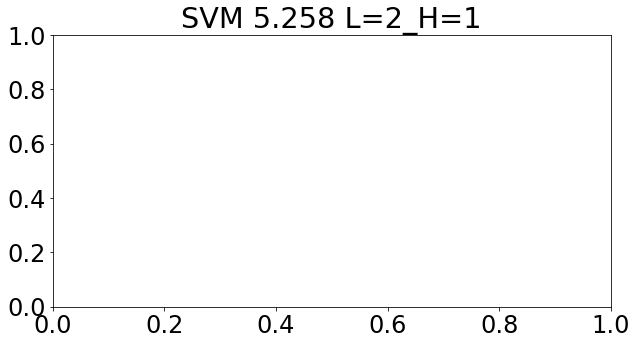

In [ ]:
def tracerLC(logs):
  for i in range(len(logs)):
    title=str(logs.iloc[i,0])+" "+str(logs.iloc[i,1])+" "+str(logs.iloc[i,2])
    sapelFig=str(logs.iloc[i,0])+"_"+str(i)
    plt.figure(figsize=(10,5))
    plt.title(title)
    curveData=logs['resultcvRMSE'].iloc[i]
    curveData["mean_train_score"].apply(lambda x:x*-1).plot(label="Train score")
    curveData["mean_test_score"].apply(lambda x:x*-1).plot(label="Validation score")
    #plt.savefig(directory+'/LC/'+sapelFig+'.png')
    plt.legend()
    plt.show()

tracerLC(l)

In [ ]:
"""plt.figure(figsize=(20,8))
curveData=resultcv[['param_base_estimator__C','param_base_estimator__epsilon','param_base_estimator__gamma','mean_test_score','mean_train_score']].copy()
curveData['parameters(C-E-G)']=curveData['param_base_estimator__C'].map(str)+'--'+curveData['param_base_estimator__epsilon'].map(str)+'--'+curveData['param_base_estimator__gamma'].map(str)
plt.plot(curveData['parameters(C-E-G)'][1:25],curveData['mean_train_score'][1:25])"""

"plt.figure(figsize=(20,8))\ncurveData=resultcv[['param_base_estimator__C','param_base_estimator__epsilon','param_base_estimator__gamma','mean_test_score','mean_train_score']].copy()\ncurveData['parameters(C-E-G)']=curveData['param_base_estimator__C'].map(str)+'--'+curveData['param_base_estimator__epsilon'].map(str)+'--'+curveData['param_base_estimator__gamma'].map(str)\nplt.plot(curveData['parameters(C-E-G)'][1:25],curveData['mean_train_score'][1:25])"

In [ ]:
print(l[["min RMSE","min MAE"]].min())
print(l[["max R2"]].max())

min RMSE   0.184
min MAE    0.129
dtype: float64
max R2   1.000
dtype: float64


In [ ]:
listminrmse=[]
listminmae=[]
listmodelmse=[]
listmodemmae=[]

koungolo=list()
rows=list()

for i in range(len(listdesLogs)):
  print("Imput",listdesLogs[i].imput)
  print("Normalized",listdesLogs[i].normalized)
  print("Method",listdesLogs[i].method)
  #print("mse list",listdesLogs[i].listrmse)
  #print("mae list",listdesLogs[i].listmae)
  #print("model list",listdesLogs[i].listmodel)
  rmse,model1=listdesLogs[i].minrmse()
  mae,model2=listdesLogs[i].minmae()
  listminrmse.append(rmse)
  listmodelmse.append(model1)
  listminmae.append(mae)
  listmodemmae.append(model2)
  #rows.append(listdesLogs[i].imput,listdesLogs[i].normalized)
  

Imput 
Normalized 
Method SVM


ValueError: ignored

In [ ]:
listmodelmse

In [ ]:
for i in range(len(listdesLogs)):
  print("imput Perso")
  print(listdesLogs[i].imput)
  print("type Normalized")
  print(listdesLogs[i].normalized)
  print("Method")
  print(listdesLogs[i].method)
  print("liste MSE")
  print(listdesLogs[i].listrmse)
  print("liste MAE")
  print(listdesLogs[i].listmae)
  print("liste Model")
  print(listdesLogs[i].listmodel)

imput Perso

type Normalized

Method
SVM
liste MSE
[1.174, 1.32, 1.437]
liste MAE
[0.668, 0.806, 0.911]
liste Model
['L=1_H=1', 'L=1_H=2', 'L=1_H=3']
imput Perso

type Normalized

Method
SVM
liste MSE
[1.145, 1.292, 1.404]
liste MAE
[0.703, 0.836, 0.929]
liste Model
['L=2_H=1', 'L=2_H=2', 'L=2_H=3']
imput Perso

type Normalized

Method
SVM
liste MSE
[1.142, 1.282, 1.384]
liste MAE
[0.706, 0.833, 0.919]
liste Model
['L=3_H=1', 'L=3_H=2', 'L=3_H=3']
imput Perso

type Normalized

Method
LSTM
liste MSE
[1.159, 1.296, 1.407]
liste MAE
[0.671, 0.797, 0.895]
liste Model
['L=1_H=1', 'L=1_H=2', 'L=1_H=3']
imput Perso

type Normalized

Method
LSTM
liste MSE
[1.143, 1.288, 1.389]
liste MAE
[0.724, 0.842, 0.92]
liste Model
['L=2_H=1', 'L=2_H=2', 'L=2_H=3']
imput Perso

type Normalized

Method
LSTM
liste MSE
[1.157, 1.301, 1.384]
liste MAE
[0.737, 0.853, 0.923]
liste Model
['L=3_H=1', 'L=3_H=2', 'L=3_H=3']
imput Perso

type Normalized

Method
WANN
liste MSE
[0.518, 0.64, 0.725]
liste MAE
[0.277, 0.

In [ ]:
i=0
j=0
#ligne=4
col=4
ligne=int(len(listHistory)/col)
fig,ax=plt.subplots(ligne,col,sharex=True, figsize=(16,9))
#fig,ax=plt.subplots(ligne,col,sharex=True,gridspec_kw={'width_ratios': [3,3,3,3]} )
for l in listHistory:
    ax[i,j].plot(listHistory.get(l).history['loss'])
    #ax[i,j].plot(listHistory.get(l).history['val_loss'])
    ax[i,j].set_title(l)
    if i < ligne and j < col:
        j=j+1
        #i=i+1
    if j==col:
        j=0
        i=i+1
plt.tight_layout() 
plt.savefig("lstmLC.png")

<Figure size 1152x648 with 0 Axes>

In [ ]:
i=0
j=0
col=4
ligne=int(len(listHistory2)/col)
fig,ax=plt.subplots(ligne,col,sharex=True, figsize=(16,9))
#fig,ax=plt.subplots(ligne,col,sharex=True,gridspec_kw={'width_ratios': [3,3,3,3]} )
for l in listHistory2:
    ax[i,j].plot(listHistory2.get(l).history['loss'])
    ax[i,j].plot(listHistory2.get(l).history['val_loss'])
    ax[i,j].set_title(l)
    if i < ligne and j < col:
        j=j+1
    if j==col:
        j=0
        i=i+1
plt.tight_layout() 
plt.savefig("wannLC.png")

<Figure size 1152x648 with 0 Axes>